# 필요한 라이브러리 import

In [11]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# DeepLab 모델 준비

In [2]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/Ex_7/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/Ex_7/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f2e8dd35340>)

# 사진 준비 

(1440, 1080, 3)
(1440, 1080, 3)
(1280, 960, 3)
(1440, 1080, 3)


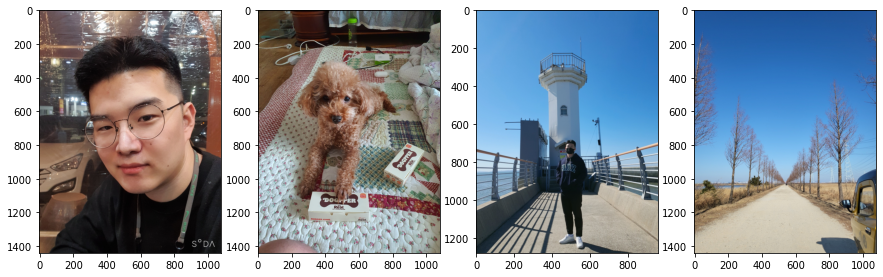

In [9]:
# 인물 모드 사진
img_path1 = os.getenv('HOME')+'/aiffel/Ex_7/images/img.png'
img_orig1 = cv2.imread(img_path1) 
# 강아지 사진
img_path2 = os.getenv('HOME')+'/aiffel/Ex_7/images/my_dog.png'
img_orig2 = cv2.imread(img_path2)
# 크로마키 인물 사진
img_path3 = os.getenv('HOME')+'/aiffel/Ex_7/images/my_image.png'
img_orig3 = cv2.imread(img_path3) 
# 크로마키 배경 사진
img_path4 = os.getenv('HOME')+'/aiffel/Ex_7/images/background.png'
img_orig4 = cv2.imread(img_path4)

print(img_orig1.shape)
print(img_orig2.shape)
print(img_orig3.shape)
print(img_orig4.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))

plt.show()

In [12]:
# Segmentation 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [13]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [14]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 색상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [15]:
# RGB
print(colormap[15])  # person
print(colormap[12])  # dog

[192 128 128]
[ 64   0 128]


# image segmentation 함수화

In [16]:
def image_segmentation(img_path, class_ids, img_bg):  # img_bg : 배경 사진
    
    # Segmentation 모델에 이미지 입력
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    #모델에서 세그멘테이션된 이미지 확인
    plt.imshow(output)
    plt.show()
    
    #세그멘테이션된 물체 확인
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
    
    # 추출 색상값 지정
    if class_ids == 15:  # person. RGB -> BGR  
        seg_color = (128, 128, 192)
    elif class_ids == 12:  # dog. RGB -> BGR
        seg_color = (128, 0, 64)
    
    # seg_color로만 이루어진 마스크 생성
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    seg_map = np.all(output==seg_color, axis=-1)
    print(seg_map.shape)
    plt.imshow(seg_map, cmap='gray')
    plt.show()
    
    # 원래 이미지와 겹쳐 보고 세그멘테이션이 얼마나 잘 되었는지 알아보기
    img_show = cv2.imread(img_path).copy()
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.4, color_mask, 0.6, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # Blur 처리
    if img_path != img_bg:  # 크로마키 배경 blur X  
        img_orig_blur = cv2.imread(img_bg)  
    else:  # 그 외 배경이 같다면 blur 처리
        img_orig_blur = cv2.blur(cv2.imread(img_bg), (15,15))  # blurring kernel size. 다양하게 바꿔보세요
          
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 배경영상과 사람영상 합치기
    img_concat = np.where(img_mask_color==255, cv2.imread(img_path), img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return img_concat

# 인물 사진 모드

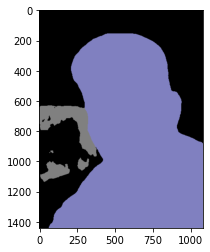

background
car
person
(1440, 1080)


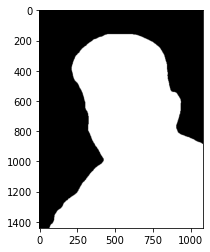

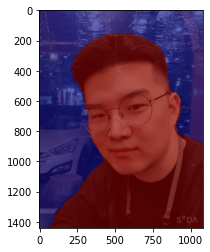

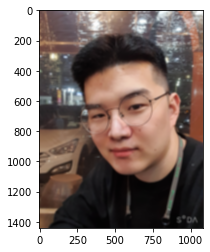

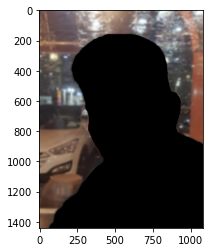

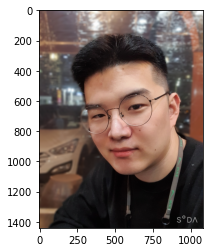

In [18]:
img_seg_dog = image_segmentation(img_path1, 15, img_path1)

# 강아지 사진 모드

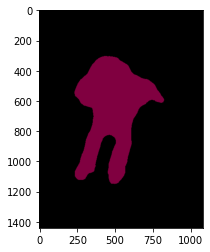

background
dog
(1440, 1080)


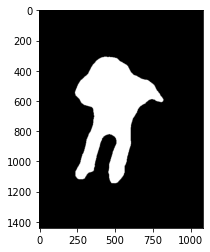

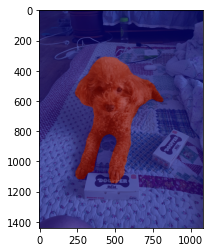

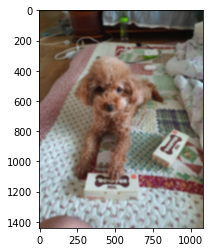

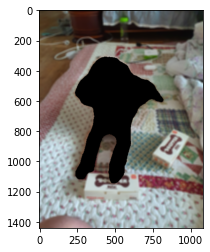

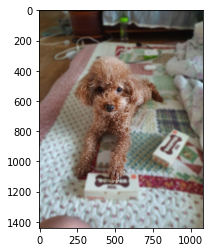

In [17]:
img_seg_dog = image_segmentation(img_path2, 12, img_path2)

# 크로마키 모드

In [24]:
# image resize
from PIL import Image

img = Image.open('/aiffel/aiffel/Ex_7/images/my_image.png')
img_resize = img.resize((1080, 1440))

img_resize_lanczos = img.resize((1080, 1440), Image.LANCZOS)
img_resize_lanczos.save('/aiffel/aiffel/Ex_7/images/my_image_lanczos.png')

In [25]:
img_path3 = os.getenv('HOME')+'/aiffel/Ex_7/images/my_image_lanczos.png'
img_orig3 = cv2.imread(img_path3)

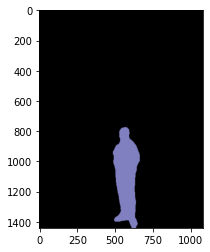

background
person
(1440, 1080)


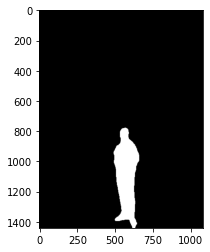

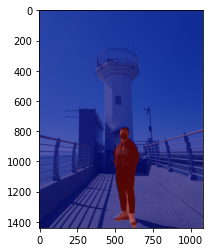

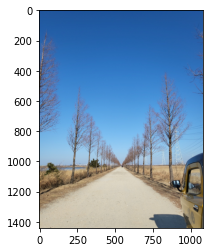

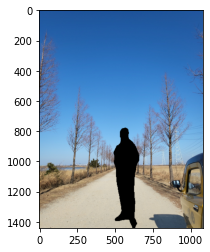

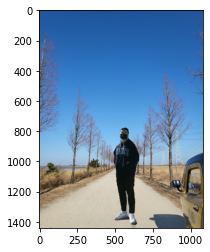

In [26]:
img_seg_chro = image_segmentation(img_path3, 15, img_path4)

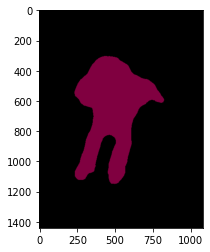

background
dog
(1440, 1080)


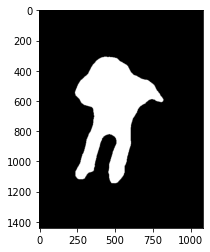

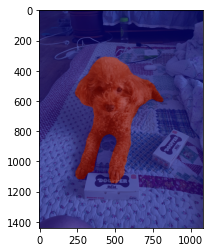

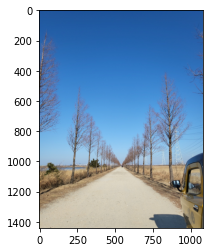

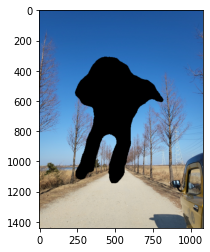

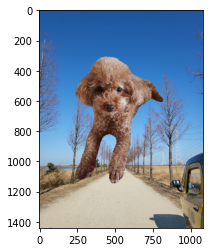

In [28]:
img_seg_chro = image_segmentation(img_path2, 12, img_path4)

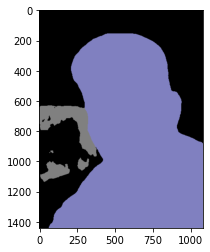

background
car
person
(1440, 1080)


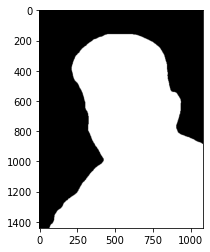

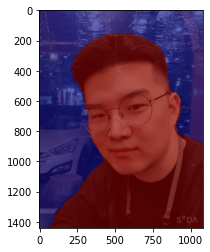

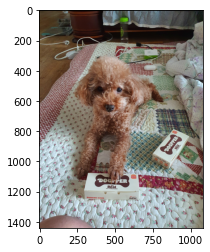

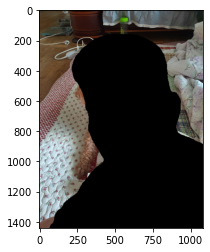

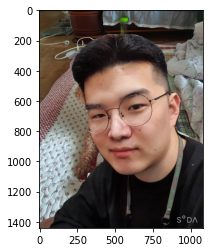

In [29]:
img_seg_chro = image_segmentation(img_path1, 15, img_path2)

# 문제점 찾기

- 분명 문제점은 있을거다...음...사진을 좀 더 복잡(?)한 것으로 골랐어야 하나도 싶다.
- 사실 블러처리 사진도 거리가 애매하긴 해도 결과물은 잘 나온것도 같다.
- 크로마키 결과에서는 인물사진의 안경이 짤린점은 문제점(?)으로 나름 보이고 
- 등대사진에서의 다리 사이도 같이 딸려온것 같다.(다만 땅의 색이 비슷해서 잘 나온 것 처럼 보이는 것 같다.)
- 경계선도 살짝(?)은 부자연 스러워 보이기도 한다.

# 해결책

...어렵당...ㅠ
- CV를 잘모르기도 하고 검색결과 나름 DeepLab V3+가 좋은 성능을 가진 모델이라고 많이 쓰여있다.
- 더 좋을라면...흠 이번에 발표한 Meta의 Data2vec이라도 쓴 모델이려나..(잘모른다...언젠가 논문 읽어는 봐야지...)<br>
[Data2vec](https://ai.facebook.com/research/data2vec-a-general-framework-for-self-supervised-learning-in-speech-vision-and-language/)
- 음 그냥 뭔가 생각나는대로라면 저런 섬세한 부분까지 labeling과 masking을 해서 (예를 들면 person에서도 hand, leg, face 등등 더 나눠서..?)해주는 모델이라면 당연히 잘되겠지...구현을...
- 자율주행에 필요한 LIDAR 나 더현대서울의 무인판매점의 카메라 같은 정도의 성능의 모델은 어떤가...?

# 회고

- 사진을 잘 골라보자. (데이터의 중요성)
- 좋은 성능의 모델을 써보았지만 아직은 사소하거나 자세한 부분까지는 커버가 안되는 것 같다.
- 물론 더 거대한 모델이나 좋은 데이터를 쓴다면 더 성능이 좋아지겠지만...
- 뭔가 포토샵하는거 같아서 재밌긴 했다.